In [65]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis

In [66]:
vphi_data = 'v_dataset.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [67]:
pd.set_option('display.max_columns', None)

df_v.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_phi_error,v_R,v_Z,v_R_error,v_Z_error
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,3.438279,-14.428048,4.529900,0.079977,0.326857
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,8.774407,42.346437,-2.860027,0.288987,1.354615
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,1.781392,-51.045366,13.944756,0.045217,0.210527
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,8.804845,62.829005,-53.068842,0.313884,4.840848
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,4.733542,1.866465,13.969564,0.132801,0.354141


In [68]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]

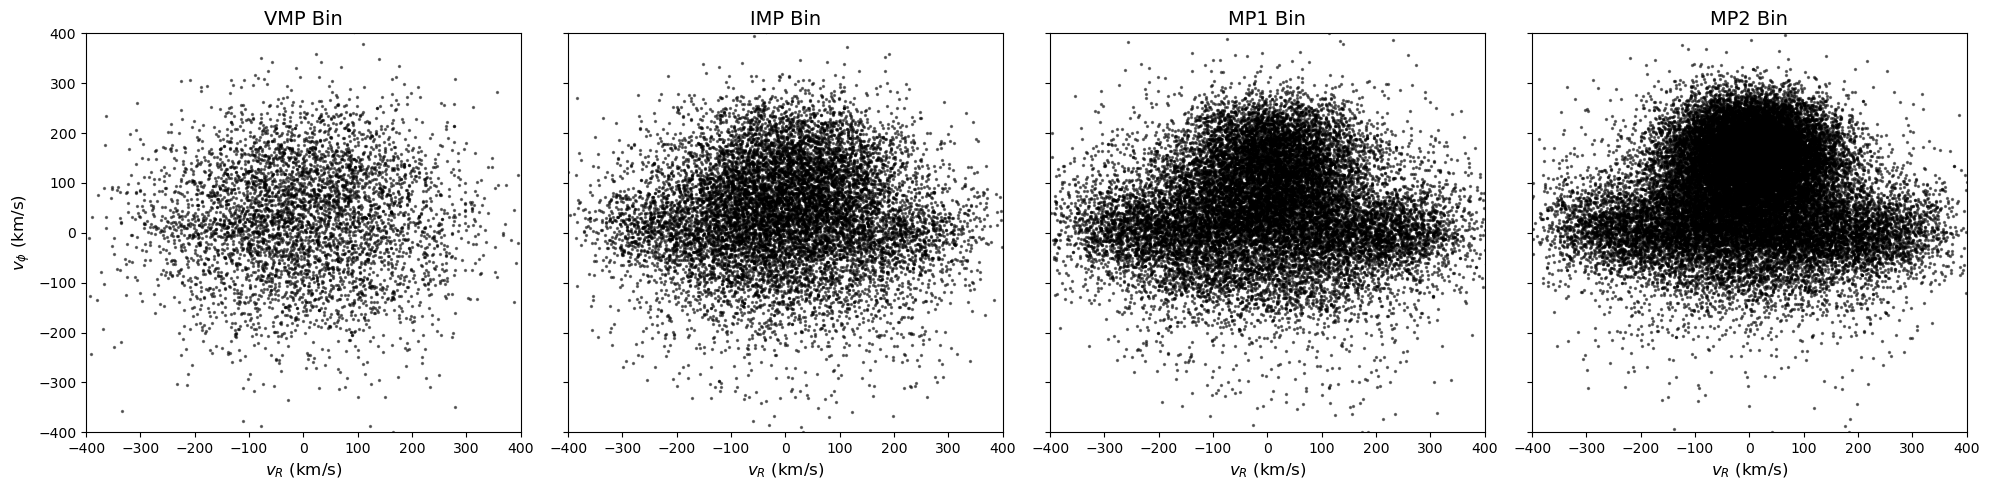

In [69]:
# Metallicity bins for GMM
metallicity_bins = {
    "VMP": (-3.0, -2.0),  # Very metal-poor
    "IMP": (-2.0, -1.6),  # Intermediate metal-poor
    "MP1": (-1.6, -1.3),  # Metal-poor 1
    "MP2": (-1.3, -1.0)   # Metal-poor 2
}

# Create a figure with subplots for each metallicity bin
fig, axes = plt.subplots(1, len(metallicity_bins), figsize=(20, 5), sharex=True, sharey=True)

for idx, (bin_name, (mh_min, mh_max)) in enumerate(metallicity_bins.items()):
    df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

    if df_bin.empty:
        continue

    # Scatter plot of v_phi vs v_R
    ax = axes[idx]
    ax.scatter(df_bin["v_R"], df_bin["v_phi"], s=2, alpha=0.5, color="black")

    # Titles and labels
    ax.set_title(f"{bin_name} Bin", fontsize=14)
    ax.set_xlabel(r"$v_R$ (km/s)", fontsize=12)
    if idx == 0:
        ax.set_ylabel(r"$v_\phi$ (km/s)", fontsize=12)

# Set x and y limits for uniform scale
plt.xlim(-400, 400)
plt.ylim(-400, 400)

plt.tight_layout()
plt.show()


In [62]:
import numpy as np

# Store covariance matrices for each metallicity bin
cov_matrices = {}

# Loop through each metallicity bin and compute the covariance matrix
for bin_name, (mh_min, mh_max) in metallicity_bins.items():
    # Filter the dataset for the metallicity bin
    df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

    if df_bin.empty:
        print(f"Skipping {bin_name}: No data available.")
        continue

    # Compute covariance matrix for v_R, v_Z, v_phi
    cov_matrix = df_bin[["v_R", "v_Z", "v_phi"]].cov().values  # Convert to NumPy array

    # Store in dictionary
    cov_matrices[bin_name] = cov_matrix

    # Print the covariance matrix for debugging
    print(f"\nCovariance Matrix for {bin_name}:")
    print(cov_matrix)



Covariance Matrix for VMP:
[[18946.47374544    27.5443379    267.51743052]
 [   27.5443379  11251.39226232    56.05772289]
 [  267.51743052    56.05772289 13101.21669611]]

Covariance Matrix for IMP:
[[20050.3012134     22.36915048   128.19496023]
 [   22.36915048  8094.7127151   -266.61214746]
 [  128.19496023  -266.61214746 11253.17992045]]

Covariance Matrix for MP1:
[[22511.87436982  -137.79396817   229.05978151]
 [ -137.79396817  7223.15608821  -388.99197681]
 [  229.05978151  -388.99197681 10637.13437058]]

Covariance Matrix for MP2:
[[16158.43101839   -43.53905999   173.58651589]
 [  -43.53905999  5745.74833155   -96.40249488]
 [  173.58651589   -96.40249488  9972.12553398]]


In [63]:
import numpy as np

# Metallicity bins for GMM
metallicity_bins = {
    "VMP": (-3.0, -2.0),  # Very metal-poor
    "IMP": (-2.0, -1.6),  # Intermediate metal-poor
    "MP1": (-1.6, -1.3),  # Metal-poor 1
    "MP2": (-1.3, -1.0)   # Metal-poor 2
}

# Store diagonal covariance matrices for each metallicity bin
cov_matrices_diagonal = {}

# Loop through each metallicity bin and compute the diagonal covariance matrix
for bin_name, (mh_min, mh_max) in metallicity_bins.items():
    # Filter the dataset for the metallicity bin
    df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

    if df_bin.empty:
        print(f"Skipping {bin_name}: No data available.")
        continue

    # Compute covariance matrix for v_R, v_Z, v_phi
    full_cov_matrix = df_bin[["v_R", "v_Z", "v_phi"]].cov().values  # Full covariance matrix

    # Extract only the diagonal elements (variances)
    diag_cov_matrix = np.diag(np.diag(full_cov_matrix))  # Set off-diagonal elements to zero

    # Store in dictionary
    cov_matrices_diagonal[bin_name] = diag_cov_matrix

    # Print the diagonal covariance matrix for debugging
    print(f"\nDiagonal Covariance Matrix for {bin_name}:")
    print(diag_cov_matrix)



Diagonal Covariance Matrix for VMP:
[[18946.47374544     0.             0.        ]
 [    0.         11251.39226232     0.        ]
 [    0.             0.         13101.21669611]]

Diagonal Covariance Matrix for IMP:
[[20050.3012134      0.             0.        ]
 [    0.          8094.7127151      0.        ]
 [    0.             0.         11253.17992045]]

Diagonal Covariance Matrix for MP1:
[[22511.87436982     0.             0.        ]
 [    0.          7223.15608821     0.        ]
 [    0.             0.         10637.13437058]]

Diagonal Covariance Matrix for MP2:
[[16158.43101839     0.             0.        ]
 [    0.          5745.74833155     0.        ]
 [    0.             0.          9972.12553398]]


In [52]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define BIC computation function
def compute_bic(N, velocities, covariances, n_repeats=50, pbar=None):
    """
    Fit a GMM with N components multiple times, return min, median, max BIC.
    Uses different initializations for each trial.
    """
    logL_values = np.zeros(n_repeats)

    for i in range(n_repeats):
        gmm = pygmmis.GMM(K=N, D=3)  # 3D GMM (v_R, v_phi, v_Z)

        # **Randomly initialise means, covariances, and amplitudes**
        idx = np.random.choice(len(velocities), N, replace=False)  # Select random data points
        gmm.mean = velocities[idx]  # Initial means from random selection
        
        # Set random covariances using dataset variance
        velocity_var = np.var(velocities, axis=0)
        gmm.covar = np.array([np.diag(velocity_var * np.random.uniform(0.5, 1.5, 3)) for _ in range(N)])

        # Set random amplitudes ensuring they sum to 1
        random_amplitudes = np.random.dirichlet(alpha=np.ones(N))
        gmm.amp = random_amplitudes

        # Fit the model
        logL, _ = pygmmis.fit(gmm, velocities, covariances)

        logL_values[i] = logL  # Store log-likelihood
        pbar.update(1)  # ✅ Update TQDM progress bar

    # Compute BIC: BIC = k log(n) - 2 logL
    k_params = (1 + 3 + 6) * N - 1  # Total parameters
    n_samples = len(velocities)
    bic_values = k_params * np.log(n_samples) - 2 * logL_values

    return N, (bic_values.min(), np.median(bic_values), bic_values.max())

In [53]:
# Define range of components to test
N_components_list = np.arange(1, 9)  # 1 to 8 components

# Select only the first metallicity bin
first_bin_name = next(iter(metallicity_bins.keys()))  # Get first bin name ("VMP")
mh_min, mh_max = metallicity_bins[first_bin_name]
print(f"\nProcessing {first_bin_name} bin...")

# Filter dataset for the first metallicity bin
df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")
velocities = df_bin[["v_R", "v_phi", "v_Z"]].to_numpy()

# Assign diagonal covariance matrix to each sample
diag_cov_matrix = cov_matrices_diagonal[first_bin_name]  # Use diagonal covariance
covariances = np.repeat(diag_cov_matrix[np.newaxis, :, :], len(df_bin), axis=0)  # Expand for all samples

# Store BIC results for the first bin only
bic_results = {first_bin_name: {}}

# Create a progress bar for the first bin
with tqdm(total=len(N_components_list) * 50, desc=f"GMM BIC for {first_bin_name}") as pbar:
    for N in N_components_list:
        N, bic_values = compute_bic(N, velocities, covariances, pbar=pbar)
        bic_results[first_bin_name][N] = bic_values  # Store BIC results

print("\n✅ GMM fitting complete for first metallicity bin!")



Processing VMP bin...


GMM BIC for VMP: 100%|██████████| 400/400 [19:41<00:00,  2.95s/it]


✅ GMM fitting complete for first metallicity bin!


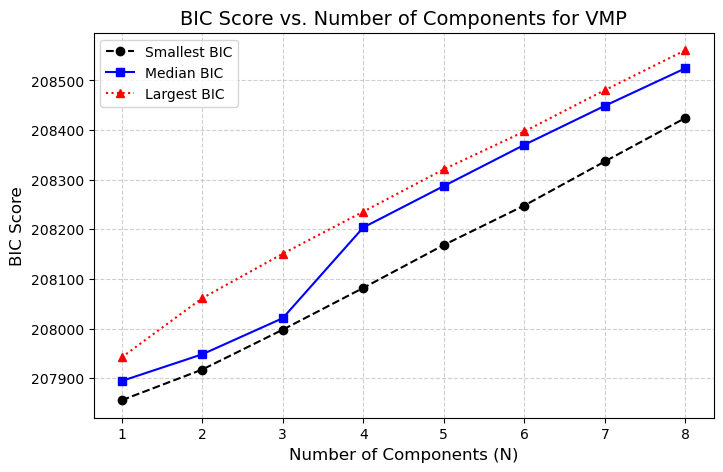

In [54]:
# Extract BIC values for the first metallicity bin
N_values = list(bic_results[first_bin_name].keys())  # Extract tested N values
bic_min = [bic_results[first_bin_name][N][0] for N in N_values]  # Smallest BIC
bic_median = [bic_results[first_bin_name][N][1] for N in N_values]  # Median BIC
bic_max = [bic_results[first_bin_name][N][2] for N in N_values]  # Largest BIC

# Plot BIC scores
plt.figure(figsize=(8, 5))
plt.plot(N_values, bic_min, marker="o", linestyle="dashed", color="black", label="Smallest BIC")
plt.plot(N_values, bic_median, marker="s", linestyle="solid", color="blue", label="Median BIC")
plt.plot(N_values, bic_max, marker="^", linestyle="dotted", color="red", label="Largest BIC")

# Formatting the plot
plt.xlabel("Number of Components (N)", fontsize=12)
plt.ylabel("BIC Score", fontsize=12)
plt.title(f"BIC Score vs. Number of Components for {first_bin_name}", fontsize=14)
plt.xticks(N_values)  # Ensure x-axis labels show all N values
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()


In [36]:
# Get the second metallicity bin
bin_names = list(metallicity_bins.keys())  # Convert dictionary keys to a list
second_bin_name = bin_names[1]  # Get the second bin name (e.g., "IMP")
mh_min, mh_max = metallicity_bins[second_bin_name]
print(f"\nProcessing {second_bin_name} bin...")

# Filter dataset for the second metallicity bin
df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")
velocities = df_bin[["v_R", "v_phi", "v_Z"]].to_numpy()

# Assign covariance matrix to each sample
covariances = np.repeat(cov_matrices[second_bin_name][np.newaxis, :, :], len(df_bin), axis=0)

# Store BIC results for the second bin
bic_results[second_bin_name] = {}

# Create a progress bar for the second bin
with tqdm(total=len(N_components_list) * 50, desc=f"GMM BIC for {second_bin_name}") as pbar:
    for N in N_components_list:
        N, bic_values = compute_bic(N, velocities, covariances, pbar=pbar)
        bic_results[second_bin_name][N] = bic_values  # Store BIC results

print("\n✅ GMM fitting complete for second metallicity bin!")



Processing IMP bin...


GMM BIC for IMP: 100%|██████████| 400/400 [26:22<00:00,  3.96s/it]


✅ GMM fitting complete for second metallicity bin!


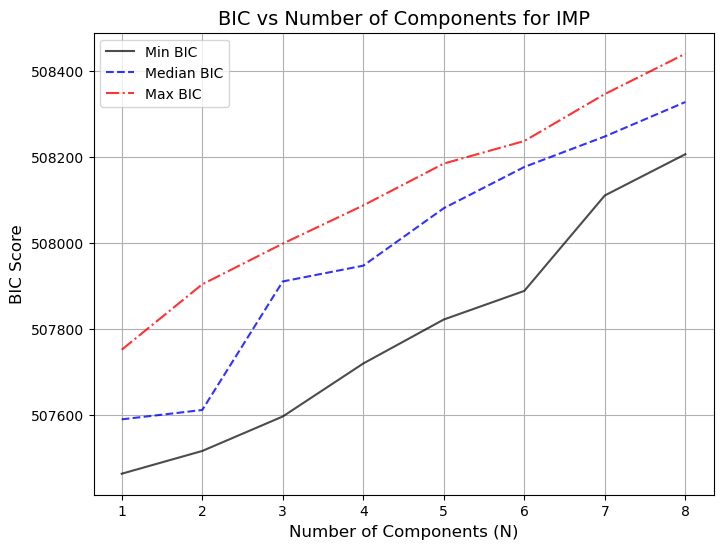

In [37]:
# Extract BIC values for the second metallicity bin
N_values = list(bic_results[second_bin_name].keys())  # Number of components
bic_min = [bic_results[second_bin_name][N][0] for N in N_values]  # Min BIC
bic_median = [bic_results[second_bin_name][N][1] for N in N_values]  # Median BIC
bic_max = [bic_results[second_bin_name][N][2] for N in N_values]  # Max BIC

# Plot BIC values
plt.figure(figsize=(8, 6))
plt.plot(N_values, bic_min, 'k-', label="Min BIC", alpha=0.7)
plt.plot(N_values, bic_median, 'b--', label="Median BIC", alpha=0.8)
plt.plot(N_values, bic_max, 'r-.', label="Max BIC", alpha=0.8)

# Labels and title
plt.xlabel("Number of Components (N)", fontsize=12)
plt.ylabel("BIC Score", fontsize=12)
plt.title(f"BIC vs Number of Components for {second_bin_name}", fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [47]:
# Get the fourth metallicity bin
bin_names = list(metallicity_bins.keys())  # Convert dictionary keys to a list
fourth_bin_name = bin_names[3]  # Get the fourth bin name (e.g., "MP2")
mh_min, mh_max = metallicity_bins[fourth_bin_name]
print(f"\nProcessing {fourth_bin_name} bin...")

# Filter dataset for the fourth metallicity bin
df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")
velocities = df_bin[["v_R", "v_phi", "v_Z"]].to_numpy()

# Assign covariance matrix to each sample
covariances = np.repeat(cov_matrices[fourth_bin_name][np.newaxis, :, :], len(df_bin), axis=0)

# Store BIC results for the fourth bin
bic_results[fourth_bin_name] = {}

# Create a progress bar for the fourth bin
with tqdm(total=len(N_components_list) * 50, desc=f"GMM BIC for {fourth_bin_name}") as pbar:
    for N in N_components_list:
        N, bic_values = compute_bic(N, velocities, covariances, pbar=pbar)
        bic_results[fourth_bin_name][N] = bic_values  # Store BIC results

print("\n✅ GMM fitting complete for fourth metallicity bin!")



Processing MP2 bin...


GMM BIC for MP2: 100%|██████████| 400/400 [42:39<00:00,  6.40s/it]  


✅ GMM fitting complete for fourth metallicity bin!


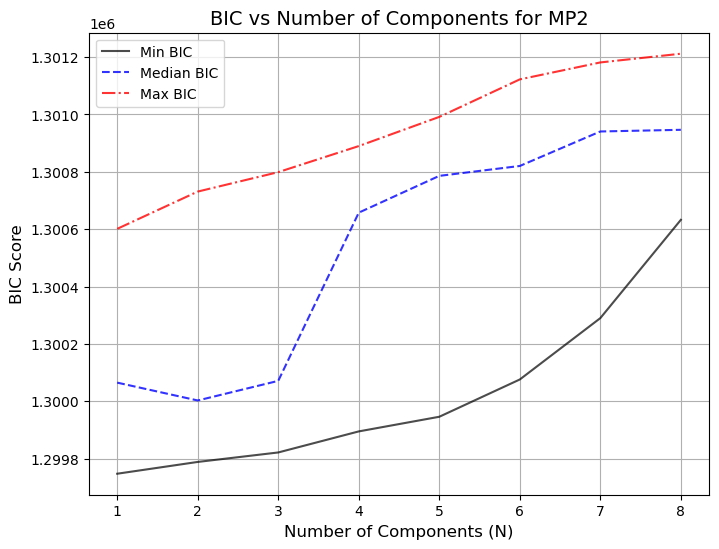

In [48]:
# Extract BIC values for the fourth metallicity bin
N_values = list(bic_results[fourth_bin_name].keys())  # Number of components
bic_min = [bic_results[fourth_bin_name][N][0] for N in N_values]  # Min BIC
bic_median = [bic_results[fourth_bin_name][N][1] for N in N_values]  # Median BIC
bic_max = [bic_results[fourth_bin_name][N][2] for N in N_values]  # Max BIC

# Plot BIC values
plt.figure(figsize=(8, 6))
plt.plot(N_values, bic_min, 'k-', label="Min BIC", alpha=0.7)
plt.plot(N_values, bic_median, 'b--', label="Median BIC", alpha=0.8)
plt.plot(N_values, bic_max, 'r-.', label="Max BIC", alpha=0.8)

# Labels and title
plt.xlabel("Number of Components (N)", fontsize=12)
plt.ylabel("BIC Score", fontsize=12)
plt.title(f"BIC vs Number of Components for {fourth_bin_name}", fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [64]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define number of bootstrap samples
n_bootstrap = 100

# Define the preferred number of components for each metallicity bin
preferred_components = {
    "VMP": 2,   # Very metal-poor
    "IMP": 4,   # Intermediate metal-poor
    "MP1": 5,   # Metal-poor 1
    "MP2": 5    # Metal-poor 2
}

# Dictionary to store results
gmm_uncertainty_results = {}

# Iterate over each metallicity bin
for bin_name, n_components in preferred_components.items():
    print(f"\nProcessing {bin_name} bin with {n_components} GMM components...")

    # Filter dataset for the metallicity bin
    mh_min, mh_max = metallicity_bins[bin_name]
    df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

    # Extract velocities
    velocities = df_bin[["v_R", "v_phi", "v_Z"]].to_numpy()

    # Set velocity uncertainties (approximate 0.1 km/s if unavailable)
    vR_error = 0.1 if "vR_error" not in df_bin else df_bin["vR_error"].to_numpy()
    vPhi_error = 0.1 if "vPhi_error" not in df_bin else df_bin["vPhi_error"].to_numpy()
    vZ_error = 0.1 if "vZ_error" not in df_bin else df_bin["vZ_error"].to_numpy()

    # Store bootstrap results
    means_list = []
    covariances_list = []

    # Perform 100 iterations with resampled velocities
    with tqdm(total=n_bootstrap, desc=f"GMM Bootstrap for {bin_name}") as pbar:
        for _ in range(n_bootstrap):
            # Resample velocities based on errors
            vR_sampled = velocities[:, 0] + np.random.normal(0, vR_error, size=len(velocities))
            vPhi_sampled = velocities[:, 1] + np.random.normal(0, vPhi_error, size=len(velocities))
            vZ_sampled = velocities[:, 2] + np.random.normal(0, vZ_error, size=len(velocities))

            sampled_velocities = np.column_stack((vR_sampled, vPhi_sampled, vZ_sampled))

            # Assign diagonal covariance matrix to each sample
            diag_cov_matrix = np.diag([vR_error**2, vPhi_error**2, vZ_error**2])
            covariances = np.repeat(diag_cov_matrix[np.newaxis, :, :], len(df_bin), axis=0)

            # Fit GMM
            gmm = pygmmis.GMM(K=n_components, D=3)
            logL, _ = pygmmis.fit(gmm, sampled_velocities, covariances)

            # Store means and covariance matrices
            means_list.append(gmm.mean)
            covariances_list.append(gmm.covar)

            pbar.update(1)

    # Convert results to arrays for easy statistical computation
    means_list = np.array(means_list)  # Shape: (100, K, 3)
    covariances_list = np.array(covariances_list)  # Shape: (100, K, 3, 3)

    # Compute standard deviation as uncertainty
    mean_uncertainty = np.std(means_list, axis=0)  # Uncertainty in mean
    covariance_uncertainty = np.std(covariances_list, axis=0)  # Uncertainty in covariance

    # Store final results
    gmm_uncertainty_results[bin_name] = {
        "mean": np.mean(means_list, axis=0),
        "mean_uncertainty": mean_uncertainty,
        "covariance": np.mean(covariances_list, axis=0),
        "covariance_uncertainty": covariance_uncertainty
    }

    print(f"✅ Completed bootstrapping for {bin_name}")

print("\n✅ GMM bootstrapping complete!")



Processing VMP bin with 2 GMM components...


GMM Bootstrap for VMP:  41%|████      | 41/100 [01:51<02:41,  2.73s/it]


KeyboardInterrupt: 